In [82]:
'''Peak finding algorithm.'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as ss
from scipy.optimize import curve_fit
from lmfit import Model
import os
from typing import Callable

### I/O

In [18]:
datadir = r"C:\Users\Laevateinn\Documents\GitHub\LAFriOC\Spectroscopy\Data\18-03-25\20250318_trazas_corriente\ALL0001"
datadir2 = r"C:\Users\Laevateinn\Documents\GitHub\LAFriOC\Spectroscopy\Data\18-03-25\20250311_trazas_espectrocopia"
os.chdir(datadir)

In [19]:
os.listdir()

['F0001CH1.CSV', 'F0001CH2.CSV', 'F0001TEK.BMP', 'F0001TEK.SET']

In [20]:
def normalize(A):
    return (A - np.min(A)) / (np.max(A) - np.min(A))

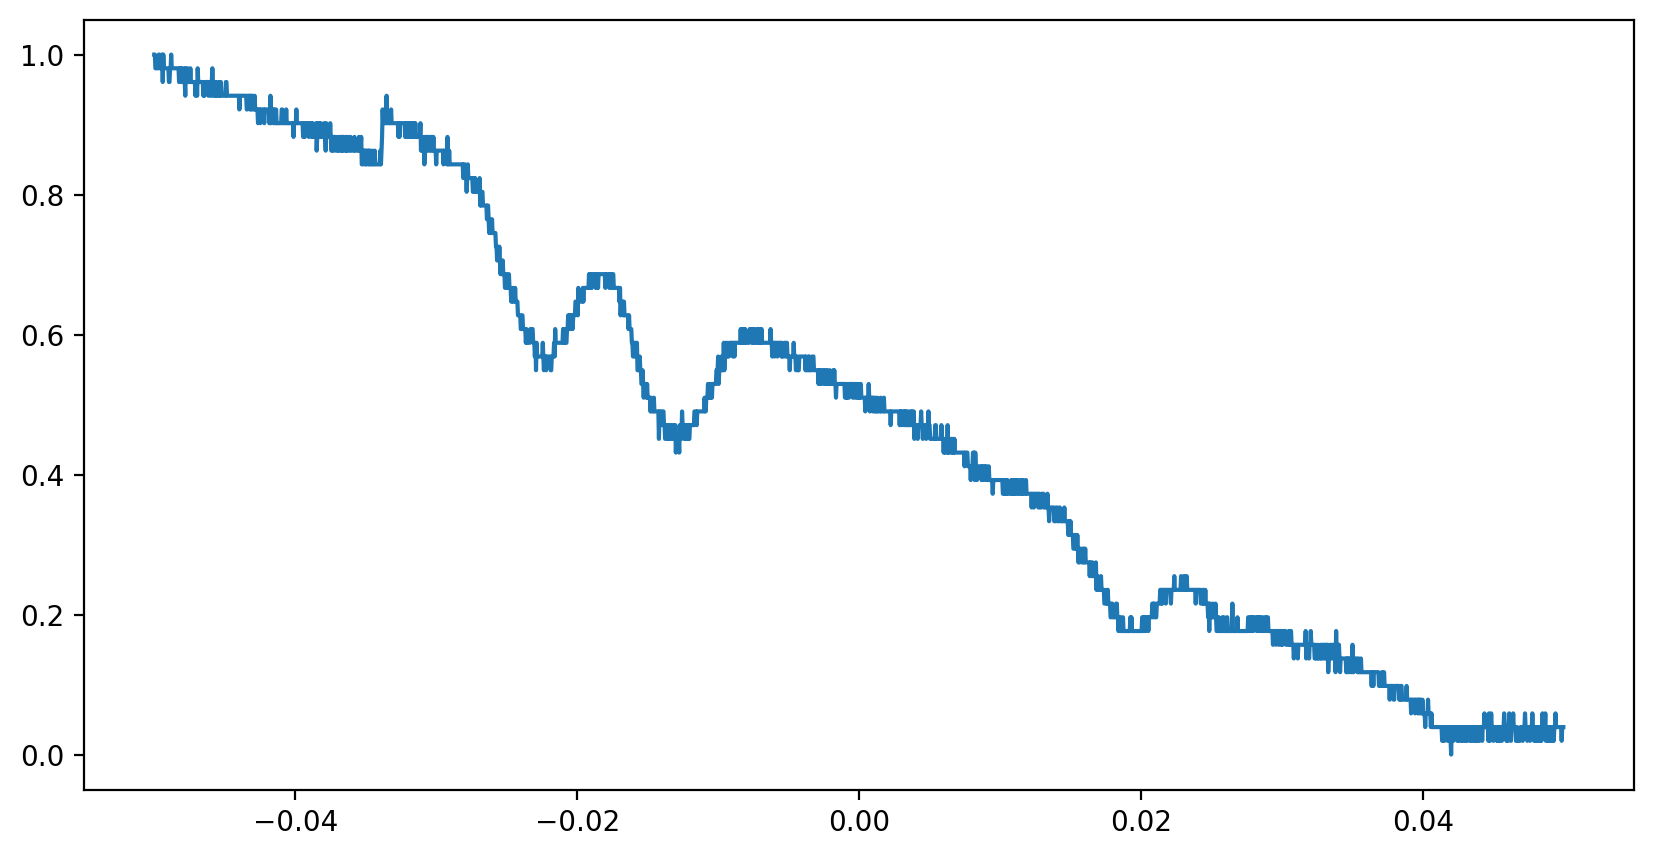

In [21]:
# There's six peaks for each fine structure well.
# Three for hyperfine structure and three for crossovers.
df = pd.read_csv(os.listdir()[0], names=["1", "2", "3", "time", "voltage", "6"])
df.head()

time = np.array(df['time'])
voltage = np.array(normalize(df['voltage']))

# lims = [-0.04, -0.03]
# lims = [-0.031, -0.02]
# lims = [-0.01, 0.005]
# lims = [0.01, 0.02]
lims = [-np.inf, np.inf]
voltage = voltage[time > lims[0]]
time = time[time > lims[0]]

voltage = voltage[time < lims[1]]
time = time[time < lims[1]]

aspect_ratio = 2
fig, ax = plt.subplots(dpi=200, figsize=(2 * 5, 5))
# voltage = clip_convolve_1D(voltage, kernel / len(kernel))
# time = time[2:-1]
ax.plot(time, voltage)

### Peak finding

In [25]:
def peak_prominences(x, peak_indeces, wlen=None):
    if not wlen:
        wlen = len(x)

    # Rounding up window length to nearest odd integer
    wlen = wlen+ (1 - wlen % 2)
    bases = []
    prominences = []
    for peak_index in peak_indeces:
        peak_value = x[peak_index]

        # Explore area to the left
        left_index = -1
        left_neighbour = x[peak_index + left_index]
        while peak_value >= left_neighbour and peak_index + left_index > 0:
            if np.abs(left_index) >= wlen // 2:
                break
            left_index -= 1
            left_neighbour = x[peak_index + left_index]

        # Explore area to the right
        right_index = 1
        right_neighbour = x[peak_index + right_index]
        while peak_value >= right_neighbour and peak_index + right_index < len(x) - 1:
            if np.abs(right_index) > wlen / 2:
                break
            right_index += 1
            right_neighbour = x[peak_index + right_index]

        left_base = peak_index + left_index + np.argmin(x[peak_index + left_index:peak_index])
        right_base = peak_index + np.argmin(x[peak_index:peak_index + right_index])
        bases.append((left_base, right_base))

        lowest_contour = np.max((x[left_base], x[right_base]))
        prominence = peak_value - lowest_contour
        prominences.append(prominence)
        
    return np.array(prominences), np.array(bases)

def find_peaks(x, height=None, threshold=None, distance=None, prominence=None,
               width=None, wlen=None):
    '''
    Parameters
    ----------
    x: array-like
        (:, )-array containing data values. Dtype must be float.
    height: array-like
        Optional. (2, )-array containing minimum and maximum height.
    threshold: array-like
        Optional. (2, )-array containing minimum and maximum threshold.
    distance: array-like
        Optional. (2, )-array containing minimum and maximum distance.
    width: array-like
        Optional. (2, )-array containing minimum and maximum width.

    Returns
    peak_indices: np.ndarray
        Peak indices for x.
    -------
    '''
    # Peak finding is performed on filtered_x to apply height filter
    # Prominences are found for the original array
    filtered_x = np.copy(x)
    # Height filtering
    if height:
        if height[0] != None:
            filtered_x[x < height[0]] = -np.inf
        if height[1] != None:
            filtered_x[height[1] < x] = -np.inf
    
    peak_indices = []
    # Edge cases (scipy doesn't consider these peaks)
    # if x[0] > x[1]:
    #     peak_indices.append(0)
    # if x[-1] > x[-2]:
    #     peak_indices.append(len(x) - 1)

    plateau = False
    for i in range(1, len(filtered_x) - 1):
        # Handling peaks at edges resulting from filtering
        if np.isneginf(filtered_x[i - 1]) or np.isneginf(filtered_x[i + 1]):
            continue
        # Handling flat peaks
        if filtered_x[i] < filtered_x[i + 1] or filtered_x[i] < filtered_x[i - 1]:
            plateau = False
        if filtered_x[i] > filtered_x[i - 1] and filtered_x[i] == filtered_x[i + 1]:
            plateau = True
            plateau_start = i
        if plateau and filtered_x[i] > filtered_x[i + 1]:
            plateau = False
            peak_indices.append((i + plateau_start) // 2)
        if filtered_x[i] > filtered_x[i - 1] and filtered_x[i] > filtered_x[i + 1]:
            peak_indices.append(i)
    peak_indices = np.array(peak_indices)

    # Prominence filtering
    if prominence:
        prominences, _ = peak_prominences(x, peak_indices)
        peak_indices = peak_indices[prominences > prominence]
    return peak_indices

[  4  17  21  23  34  83  89  98 119 127 133 140 148 163 174 191 208 221
 223 225 229 231 237]
[  4  17  21  23  34  83  89  98 119 127 133 140 148 163 174 191 208 221
 223 225 229 231 237]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


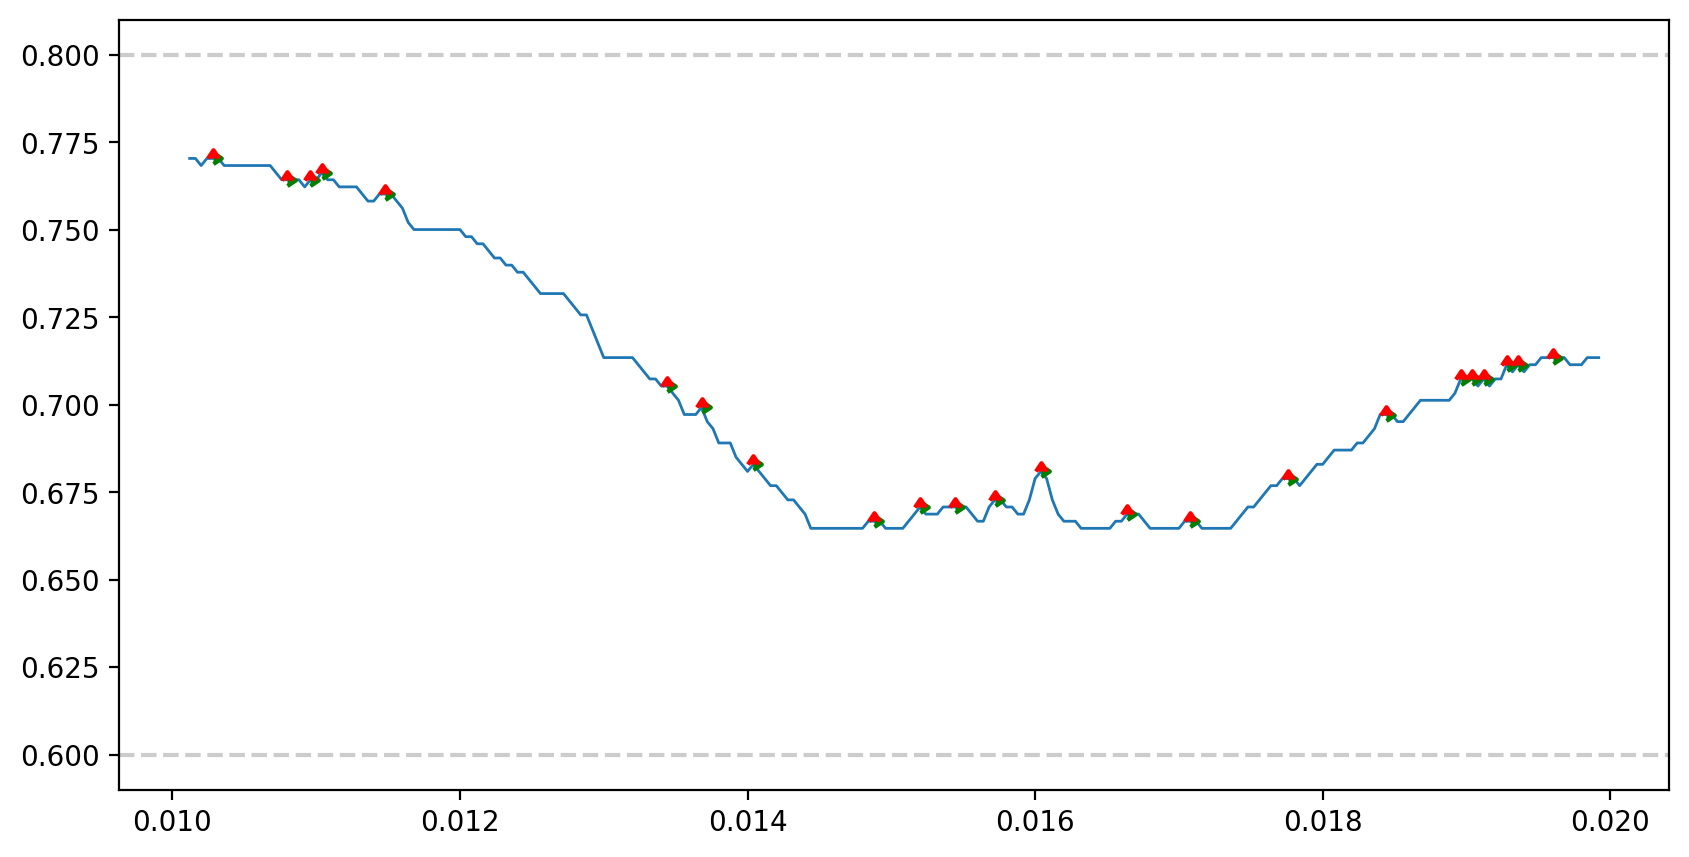

In [26]:
height1 = 0.6
height2 = 0.8
prominence = 0
peak_indices = find_peaks(voltage, height=(height1, height2), prominence=prominence)
peak_times, peak_voltages = time[peak_indices], voltage[peak_indices]

peak_indices_sp, _ = ss.find_peaks(voltage, height=(height1, height2), prominence=prominence)
peak_times_sp, peak_voltages_sp = time[peak_indices_sp], voltage[peak_indices_sp]

print(peak_indices_sp)

aspect_ratio = 2
fig, ax = plt.subplots(dpi=200, figsize=(2 * 5, 5))
ax.axhline(height1, ls='--', c="#ccc", zorder=0)
ax.axhline(height2, ls='--', c="#ccc", zorder=0)
ax.plot(time, voltage, zorder=1, lw=1)
ax.scatter(peak_times_sp, peak_voltages_sp, marker=9, c='g', s=16, zorder=2)
ax.scatter(peak_times, peak_voltages, c='r', marker=10, s=16,  zorder=2)

print(peak_indices)
print(peak_indices == peak_indices_sp)

### DFT

In [27]:
# %% DFT functions.

def DFT(h):
    '''Symmetric (k = -N/2,...,N/2 -1) discrete fourier transform.'''
    N = len(h)
    n = np.arange(0, N).reshape((1, N))
    k = np.arange(-N / 2, N / 2).reshape((N, 1))
    
    W = np.exp(-2j * np.pi * k * n / N)
    return np.matmul(W, h)

def IDFT(H):
    '''Inverse discrete fourier transform.'''
    N = len(H)
    k = np.arange(-N / 2, N / 2).reshape((1, N))
    n = np.arange(0, N).reshape((N, 1))
    
    W = np.exp(2j * np.pi * n * k / N)
    return np.matmul(W, H) / N

def full_DFT(t, f):
    '''Returns ω and DFT from raw data points.'''
    T = t[-1]
    N = len(t)
    delta_w = 2 * np.pi / T
    w = delta_w * np.arange(-N/2, N/2)
    return w, DFT(f)

def visualize_DFT(Δw, H):
    plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
    fig, axs = plt.subplot_mosaic([["Re"], ["Im"]], dpi=150)
    _, stemlines, _ = axs["Re"].stem(Δw, np.real(H), '-b', markerfmt=' ', basefmt='-b')
    plt.setp(stemlines, 'linewidth', 1)
    
    _, stemlines, _ = axs["Im"].stem(Δw, np.imag(H), '-r', markerfmt=' ', basefmt='-r')
    plt.setp(stemlines, 'linewidth', 1)

    titles = ["Real part", "Imaginary part"]
    for ax_label, title in zip(axs, titles):
        axs[ax_label].set(title=title, xlabel='$ω$ [rad]', ylabel='$F(ω)$ [u.a.]')
        axs[ax_label].grid(True, color='#ccc', ls='--')

    plt.subplots_adjust(hspace=0.5)

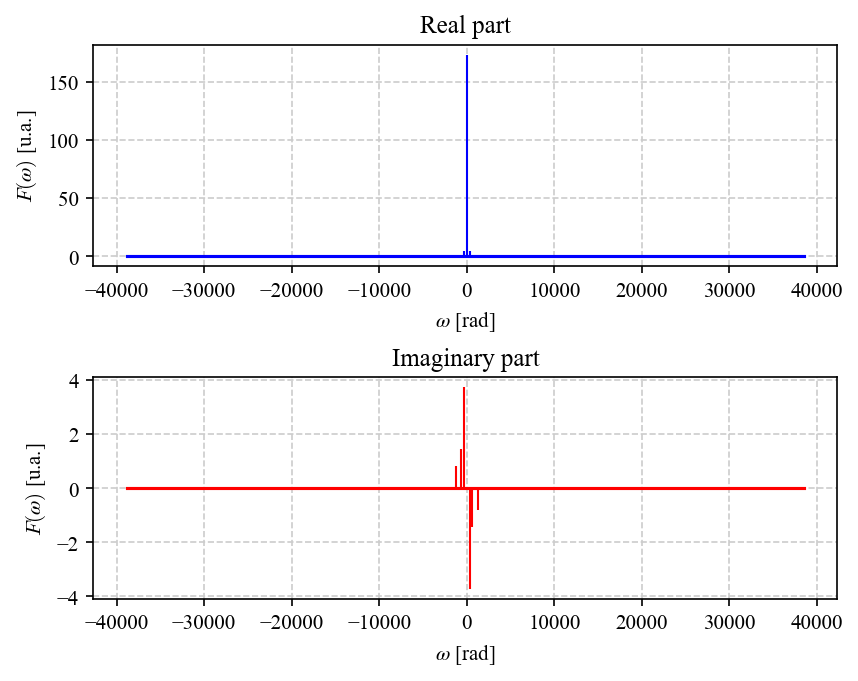

In [28]:
w, F = full_DFT(time, voltage)
# visualize_DFT(w, F)
F[np.abs(F) < 0.5] = 0

visualize_DFT(w, F)

C:\Program Files\Python310\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Program Files\Python310\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


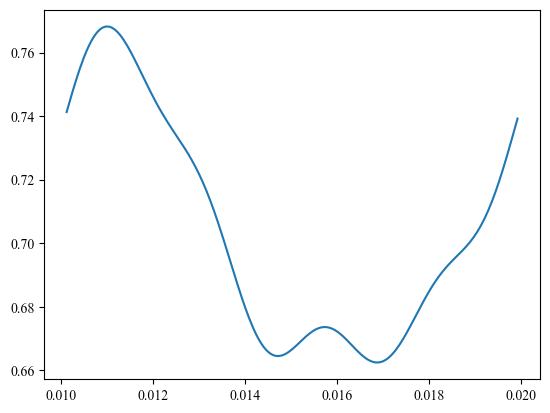

In [29]:
plt.plot(time, IDFT(F))

### Convolutions

In [27]:
# %% Convolution functions
def clip_convolve_1D(data: np.ndarray, kernel: np.ndarray):
    N = len(data)
    L = len(kernel)
    Lhalf = int(L//2)
    output = np.zeros(N - L)
    for i in range(Lhalf, N - Lhalf - int(L % 2)):
        output[i - Lhalf] = np.sum(data[i - Lhalf:i + Lhalf + int(L % 2)] * kernel)
    return output

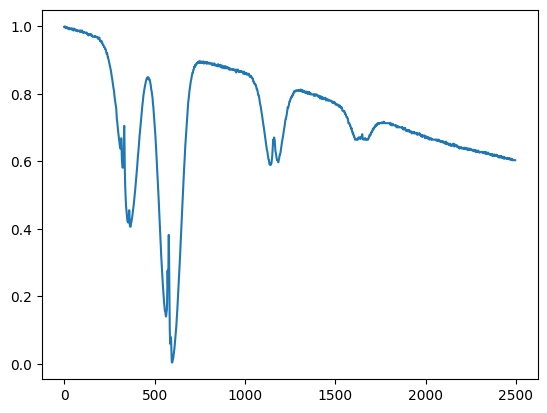

In [28]:
kernel = np.ones(3) / 3
voltage = clip_convolve_1D(voltage, kernel)
plt.plot(voltage)

### Baseline filtering

In [235]:
def get_baseline(positions: np.ndarray, voltage: np.ndarray, kernel: np.ndarray,
                 derivative_threshold: int, length_threshold: int, derivative_center: float = None, show = False):
    '''
    Filters the values for the baseline of spectroscopy traces. The algorithm is divided into three parts:
    1. Clip-convolve voltage values with a kernel and take its derivative. Values beyond a derivative_threshold
    distance from derivative_center are set to nan, leaving an array with numeric values separated by nans.
    2. If the length of the numeric clumps in the previous array is less than length_threshold, the clumps will
    be set to nan.
    3. To match the length of the original voltage array, the previous filtered array is padded and then used to
    filter the original array, i.e., values not satisfying conditions are discarded. Same is done for the original
    voltage positions array.

    The result can be displayed through a matplotlib plot.
    
    Parameters
    ----------
    positions: np.ndarray
        Relative x-positions of voltage measurements.
    voltage: np.ndarray
        Trace voltage values.
    kernel: np.ndarray
        Kernel to average voltage array.
    derivative_threshold: int
        Determines allowed distance from derivative_center.
    length_threshold: int
        Determines minumum length for derivative-filtered voltage array.
    derivative_center: float
        Optional. If not provided, derivative average is used instead.
    show: bool
        False by default. Whether to show result.

    Returns
    -------
    baseline_positions: np.ndarray
        Relative x-positions for baseline data points.
    baseline: np.ndarray
        Array containing baseline numeric values.
    '''
    
    len_kernel = int(len(kernel))
    baseline = np.copy(voltage)
    voltage_filtered = clip_convolve_1D(voltage, kernel)
    voltage_gradient = normalize(np.gradient(voltage_filtered))

    # Filter values whose distance from derivative center is greater than derivative_threshold.
    if derivative_center == None:
        derivative_center = np.mean(voltage_gradient)
    voltage_filtered[np.abs(voltage_gradient - derivative_center) > derivative_threshold] = np.nan

    # Discard clumps whose length is less than length_threshold.
    clump_slices = np.ma.clump_unmasked(np.ma.masked_invalid(voltage_filtered))
    for s in clump_slices:
        if len(voltage_filtered[s]) < length_threshold:
            voltage_filtered[s] = np.nan

    # Padding filtered voltages to match baseline shape.
    voltage_filtered_padded = np.concatenate((np.zeros(len_kernel//2),
                                       voltage_filtered,
                                       np.zeros(len_kernel//2 + int(len_kernel % 2))))
     
    # Filter baseline and baseline positions
    baseline_positions = positions[~np.isnan(voltage_filtered_padded)]
    baseline = baseline[~np.isnan(voltage_filtered_padded)]
    

    if show:
        positions_clipped = positions[len_kernel//2:-len_kernel//2 - int(len_kernel % 2)]

        fig, ax = plt.subplots(dpi=200, figsize=(2 * 5, 5))
        ax.set(title='Baseline filtering', ylabel='Normalized amplitude', xlabel='Relative position')
        ax.plot(positions, voltage, label='Normalized trace', alpha=0.5, zorder=0)
        ax.plot(positions_clipped, voltage_gradient, label='Averaged trace derivative', alpha=0.5, zorder=0)
        ax.axhline(derivative_center - derivative_threshold, ls='--', color='#ccc', label='Derivative threshold', zorder=1)
        ax.axhline(derivative_center + derivative_threshold, ls='--', color='#ccc', zorder=1)

        ax.plot(positions_clipped, voltage_filtered, label='Averaged baseline', zorder=3, alpha=0.8)
        ax.scatter(baseline_positions, baseline, label='Baseline', s=3, color='#d73031', zorder=2)

        ax.legend()
        plt.show()
    
    return baseline_positions, baseline

def fit_baseline(baseline_positions: np.ndarray, baseline: np.ndarray, show=False):
    '''Fits a quadratic polynomial to baseline data points through a np.polyfit and lmfit.'''
    f = lambda x, a, b, c: a*x**2 + b*x + c
    a0, b0, c0 = np.polyfit(baseline_positions, baseline, 2)
    model = Model(f)
    params = model.make_params(a=a0, b=b0, c=c0)
    baseline_fit = model.fit(baseline, params, x=baseline_positions)

    if show:
        print(result.fit_report())
        fig, ax = plt.subplots(dpi=200, figsize=(2 * 5, 5))
        
        ax.set(title='Baseline fitting', ylabel='Normalized amplitude', xlabel='Trace position')
        ax.scatter(baseline_positions, baseline, label='Baseline', s=3, color='#d73031', zorder=2)
        ax.plot(baseline_positions, baseline_fit.best_fit, label='Fitted baseline', zorder=1)

        # Confidence bands
        sigma1 = baseline_fit.eval_uncertainty(sigma=1)
        sigma2 = baseline_fit.eval_uncertainty(sigma=2)

        plt.fill_between(baseline_positions, baseline_fit.best_fit - sigma1, baseline_fit.best_fit + sigma1,
                        label='$1σ$', color="#AAAAAA60", zorder=-1)                         
        plt.fill_between(baseline_positions, baseline_fit.best_fit - sigma2, baseline_fit.best_fit + sigma2,
                        label='$2σ$', color="#AAAAAA10", zorder=0)

        ax.legend()
        plt.show()

    a, b, c = result.params['a'].value, result.params['b'].value, result.params['c'].value
    baseline_function = lambda x: f(x, a, b, c)
    return result, baseline_function

def zero_voltage(positions: np.ndarray, voltage: np.ndarray, kernel: np.ndarray,
                 derivative_threshold: int, length_threshold: int, derivative_center: float = None, show = False):
    '''
    Subtracts baseline from voltage measurements. Baseline is found using a combination of get_baseline and
    fit baseline.
    '''
    baseline_positions, baseline = get_baseline(time, voltage, kernel, derivative_threshold, length_threshold,
                                                derivative_center, show)
    baseline_fit, baseline_function = fit_baseline(baseline_positions, baseline, show)
    zeroed_voltage = normalize(voltage - baseline_function(positions))

    if show:
        fig, ax = plt.subplots(dpi=200, figsize=(2 * 5, 5))
        
        ax.set(title='Zeroing voltage', ylabel='Normalized amplitude', xlabel='Trace position')
        ax.plot(positions, voltage, label='Normalized trace')
        ax.plot(positions, zeroed_voltage, label='Normalized zeroed trace')
        ax.plot(positions, baseline_function(positions), label='Fitted baseline')

        ax.legend()
        plt.show()

    return zeroed_voltage, (baseline_positions, baseline), (baseline_fit, baseline_function) 
    

In [236]:
datadir = r"C:\Users\Laevateinn\Documents\GitHub\LAFriOC\Spectroscopy\Data\18-03-25\20250318_trazas_corriente\ALL0002"
datadir2 = r"C:\Users\Laevateinn\Documents\GitHub\LAFriOC\Spectroscopy\Data\18-03-25\20250311_trazas_espectrocopia"
os.chdir(datadir)

df = pd.read_csv(os.listdir()[0], names=["1", "2", "3", "time", "voltage", "6"])
time = np.array(df['time'])
voltage = np.array(normalize(df['voltage']))

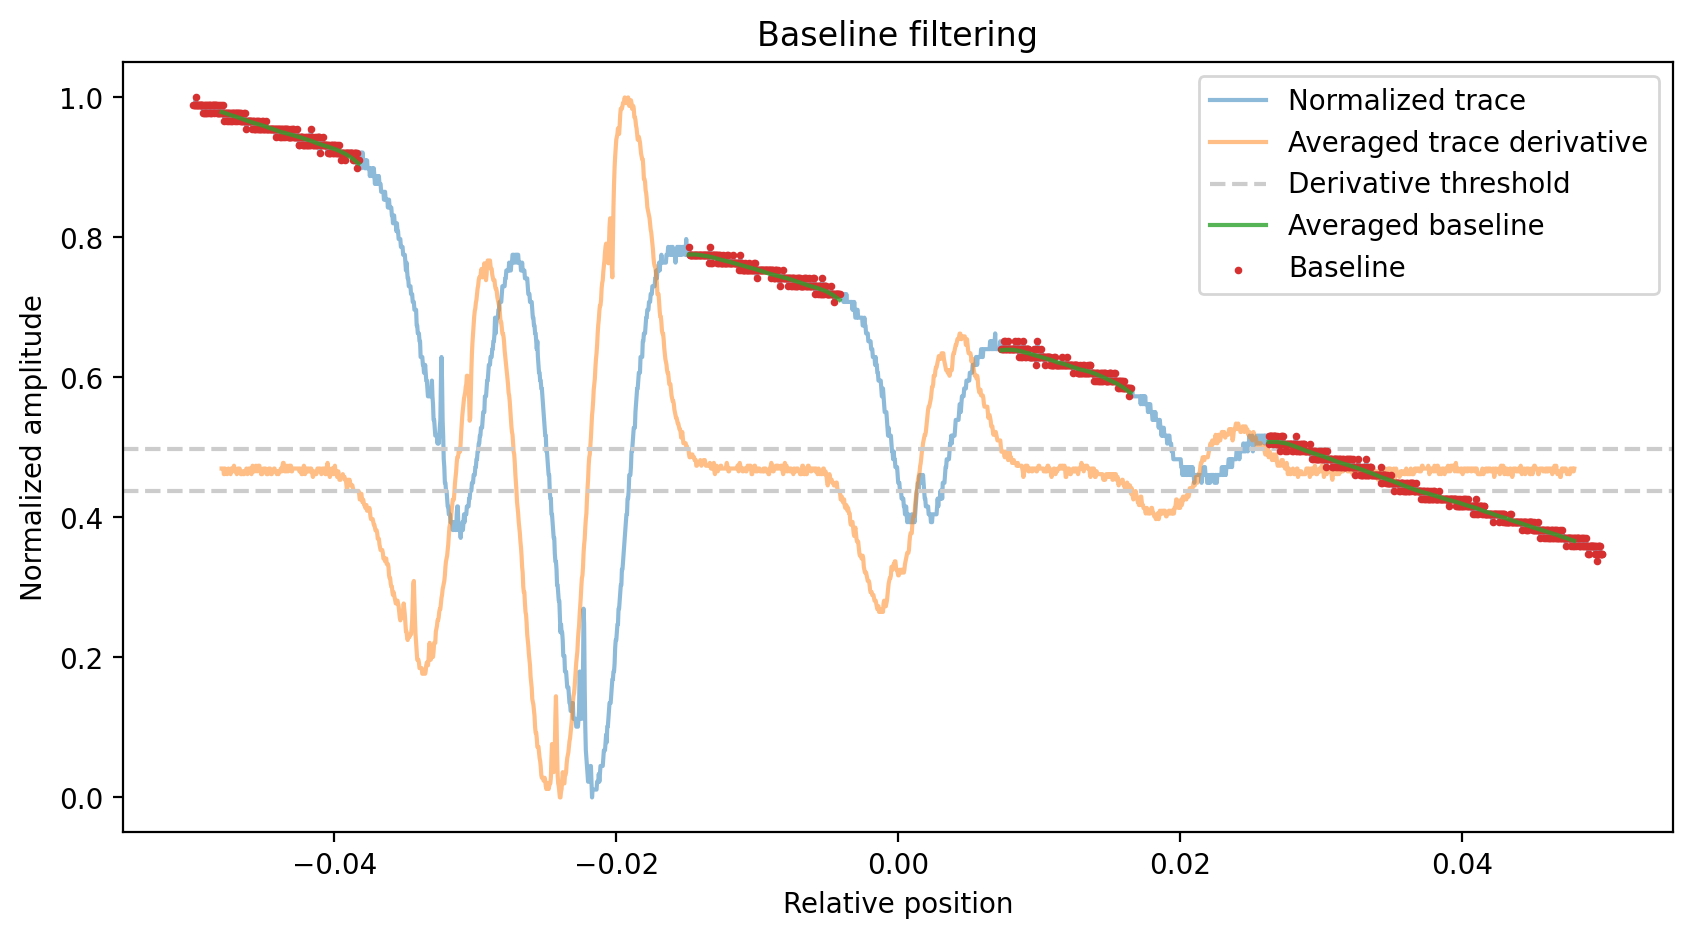

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 1259
    # variables        = 3
    chi-square         = 0.07407576
    reduced chi-square = 5.8978e-05
    Akaike info crit   = -12257.5916
    Bayesian info crit = -12242.1774
    R-squared          = 0.99636975
[[Variables]]
    a: -8.16007890 +/- 0.26529660 (3.25%) (init = -8.160079)
    b: -4.14004527 +/- 0.00712819 (0.17%) (init = -4.140045)
    c:  0.81428231 +/- 3.6541e-04 (0.04%) (init = 0.8142823)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.7676
    C(b, c) = -0.1713


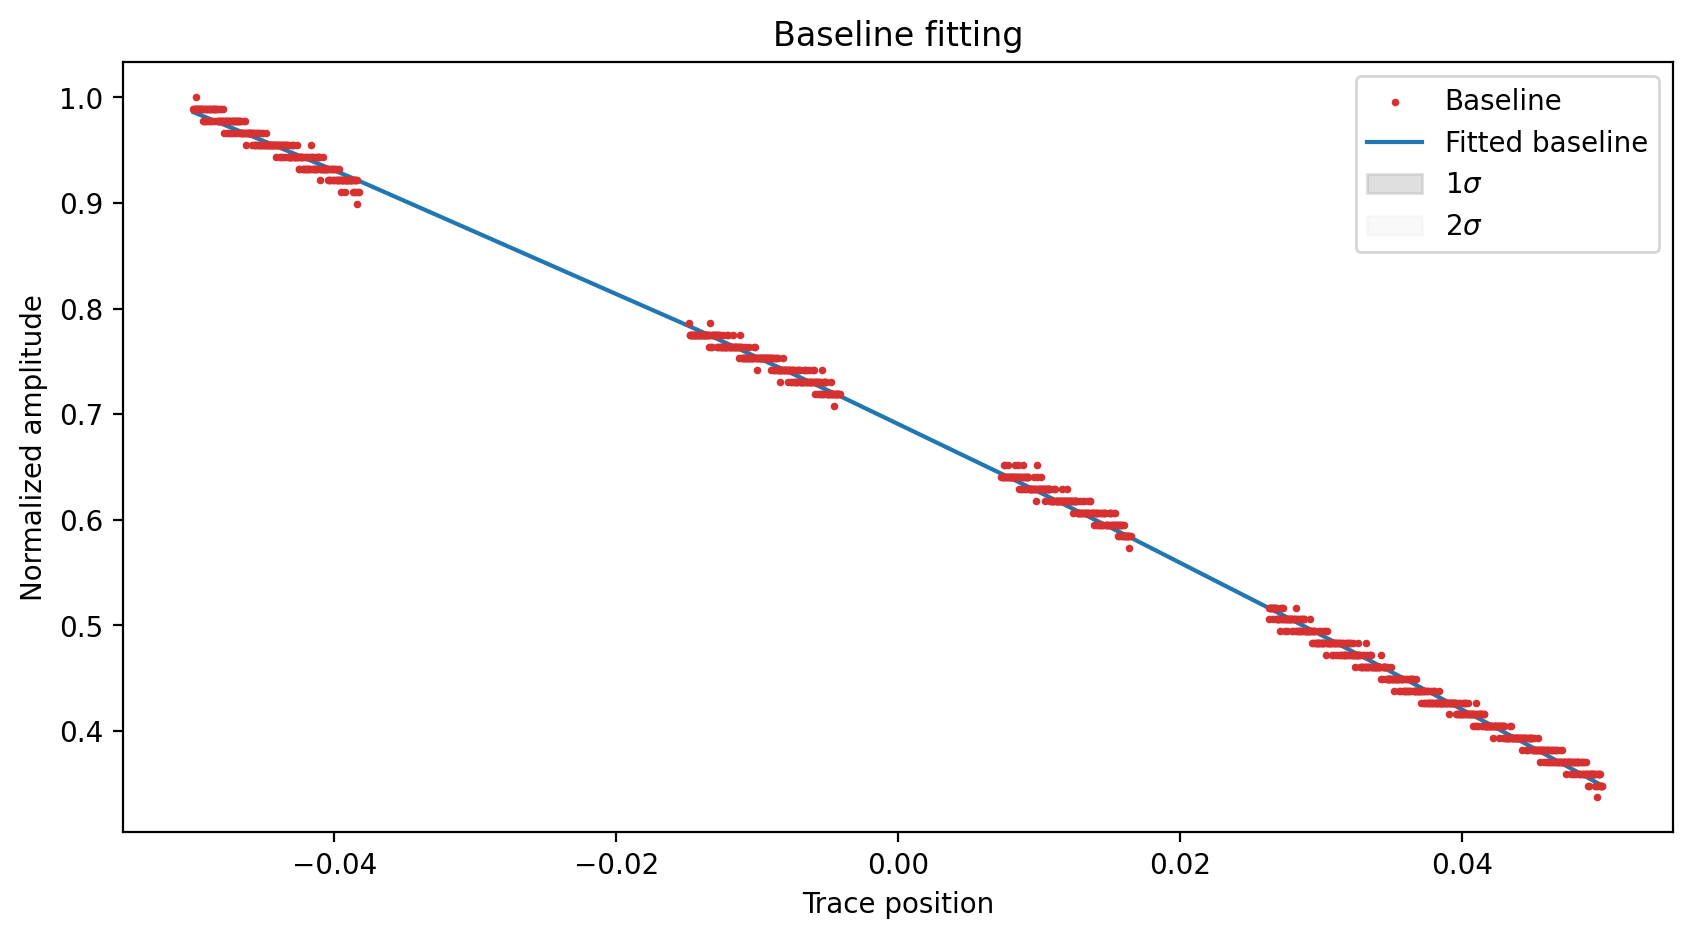

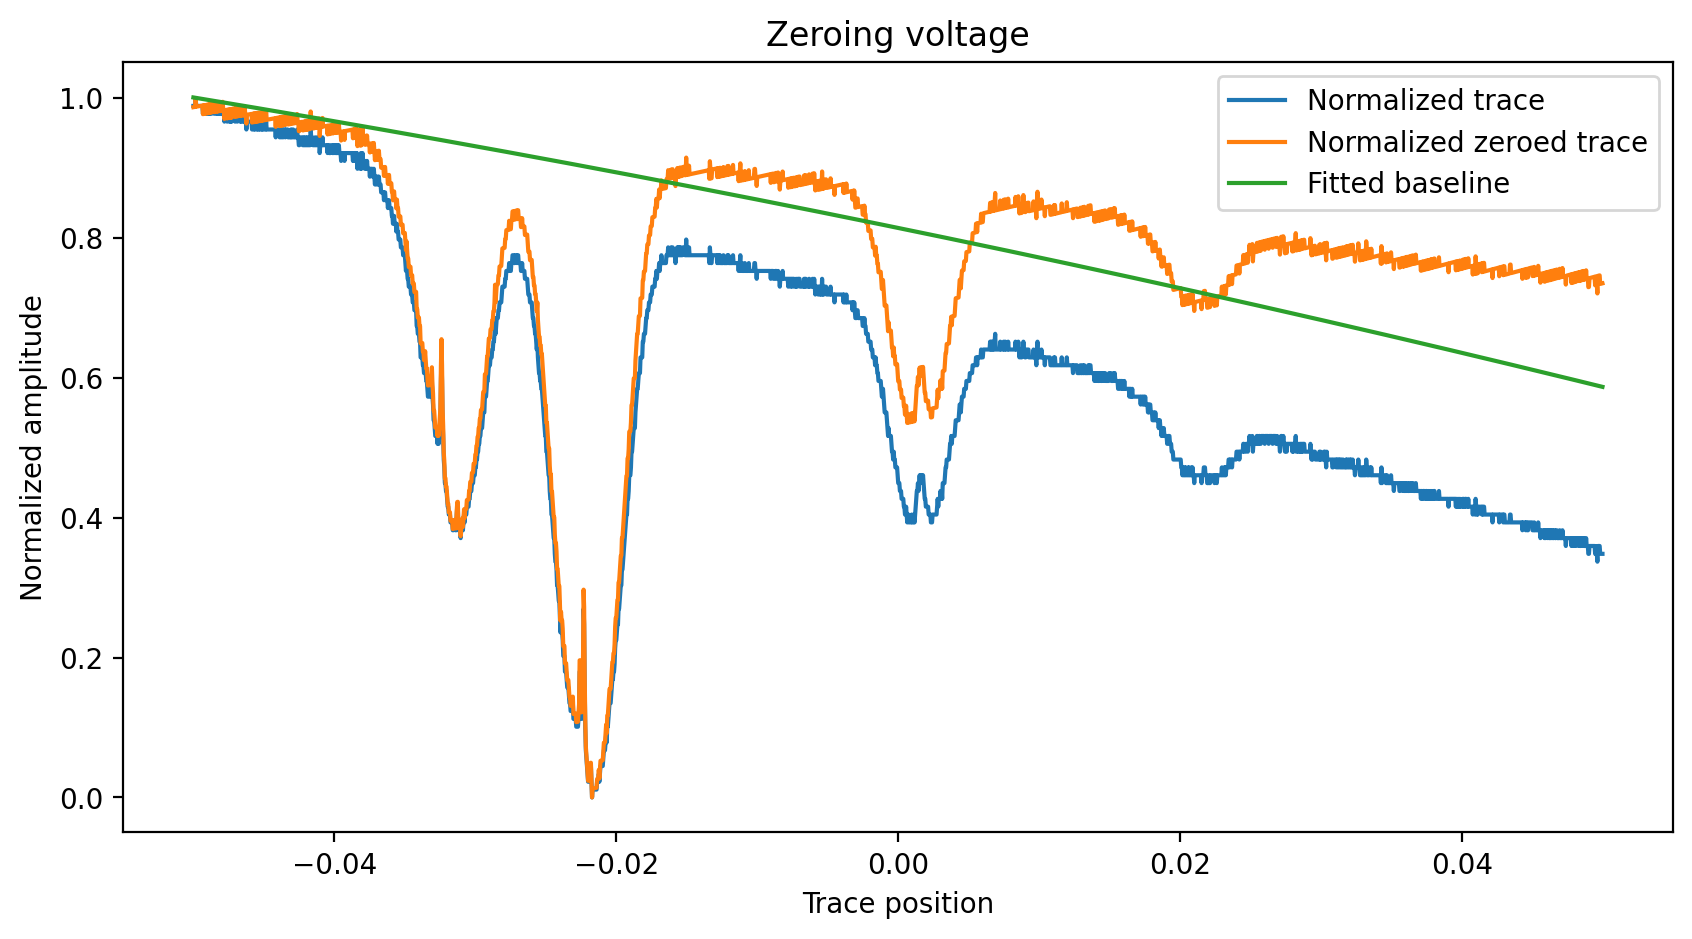

In [237]:
kernel = np.ones(100) / 100
zeroed_voltage, _, _ = zero_voltage(time, voltage, kernel, derivative_threshold=0.03, length_threshold=100, show=True)